In [1]:
import uproot
import awkward as ak
import numpy as np
import sklearn.metrics as m
import boost_histogram as bh
import glob
import os
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from cycler import cycler
import mplhep as hep
# plt.style.use(hep.style.ROOT)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

def _p4_from_ptetaphie(pt, eta, phi, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'energy': energy})
def _p4_from_ptetaphim(pt, eta, phi, mass):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'mass': mass})

from concurrent.futures import ThreadPoolExecutor
from functools import reduce
from operator import add

In [2]:
# Load samples (updated 0316)
df0 = {}
df0["ttbarsl"] = uproot.lazy(["/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_YZ_ntuple.root", "/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_FJ_ntuple_id0-499.root", "/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_woFJ_ntuple_id0-999.root"])[1100000:] # exclude training samples
df0["wjets"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/WJetsToLNu_HT150_ntuple_id0-999.root")[1100000:] # exclude training samples
df0["wwsl"] = uproot.lazy("/data/bond/licq/delphes/sm_1l/merged_ntuple/WWSL_ntuple_id0-99.root")
df0["twsl"] = uproot.lazy("/data/bond/licq/delphes/sm_1l/merged_ntuple/TWSL_ntuple_id0-99.root")
# df0["wjets_nocut"] = uproot.lazy("/data/bond/licq/delphes/sm_1l/merged_ntuple/WJetsToLNu_ntuple_id0-99.root")

df0["tbh_m60"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH60_FJ_ntuple_id0-199.root")
df0["tbh_m70"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH70_FJ_ntuple_id0-199.root")
df0["tbh_m80"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH80_FJ_ntuple_id0-199.root")
df0["tbh_m90"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH90_FJ_ntuple_id0-199.root")

df0["tbh_m100"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH100_FJ_ntuple_id0-199.root")
df0["tbh_m110"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH110_FJ_ntuple_id0-199.root")
df0["tbh_m120"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH120_FJ_ntuple_id0-199.root")
df0["tbh_m130"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH130_FJ_ntuple_id0-199.root")
df0["tbh_m140"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH140_FJ_ntuple_id0-199.root")
df0["tbh_m150"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH150_FJ_ntuple_id0-199.root")
df0["tbh_m160"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH160_FJ_ntuple_id0-199.root")


In [3]:
# total lumi for Run2 + Run3
lumi_tot = 450 # fb-1

# compute weights from un-selected events
weights = {
    "ttbarsl": (lumi_tot / 100.) * 2250000 / len(df0["ttbarsl"]), # number of events passing 1 fj selection
    "wjets": (lumi_tot / 100.) * 6290000 / len(df0["wjets"]), # number of events passing 1 fj selection
    "wwsl": (lumi_tot / 100.) * 1615000 / len(df0["wwsl"]),
    "twsl": (lumi_tot / 100.) * 1108000 / len(df0["twsl"]),

    "tbh_m60": (lumi_tot / 100.) * 33139 / len(df0["tbh_m60"]),
    "tbh_m70": (lumi_tot / 100.) * 32560 / len(df0["tbh_m70"]),
    "tbh_m80": (lumi_tot / 100.) * 32375 / len(df0["tbh_m80"]),
    "tbh_m90": (lumi_tot / 100.) * 31833 / len(df0["tbh_m90"]),
    "tbh_m100": (lumi_tot / 100.) * 31767 / len(df0["tbh_m100"]),
    "tbh_m110": (lumi_tot / 100.) * 32036 / len(df0["tbh_m110"]),
    "tbh_m120": (lumi_tot / 100.) * 32151 / len(df0["tbh_m120"]),
    "tbh_m130": (lumi_tot / 100.) * 32359 / len(df0["tbh_m130"]),
    "tbh_m140": (lumi_tot / 100.) * 32811 / len(df0["tbh_m140"]),
    "tbh_m150": (lumi_tot / 100.) * 33169 / len(df0["tbh_m150"]),
    "tbh_m160": (lumi_tot / 100.) * 33703 / len(df0["tbh_m160"]),
}
print({sam: len(df0[sam]) for sam in df0})
print(weights)

# {'ttbarsl': 2570425, 'wjets': 4157131, 'wwsl': 2198372, 'twsl': 1803005, 'wjets_nocut': 2758550}
# {'ttbarsl': 0.8753416263847418, 'wjets': 1.513062734852474, 'wwsl': 0.7346345386495098, 'twsl': 0.6145296324746742, 'wjets_nocut': 653.2417393195701}

{'ttbarsl': 5216209, 'wjets': 4841933, 'wwsl': 2198372, 'twsl': 1803005, 'tbh_m60': 492519, 'tbh_m70': 485629, 'tbh_m80': 480435, 'tbh_m90': 475480, 'tbh_m100': 473763, 'tbh_m110': 474951, 'tbh_m120': 478268, 'tbh_m130': 483679, 'tbh_m140': 489676, 'tbh_m150': 497989, 'tbh_m160': 498822}
{'ttbarsl': 1.9410648614731503, 'wjets': 5.8458057969823205, 'wwsl': 3.305855423922794, 'twsl': 2.765383346136034, 'tbh_m60': 0.30278121250144663, 'tbh_m70': 0.3017118005720416, 'tbh_m80': 0.30324081301320677, 'tbh_m90': 0.30127134684949947, 'tbh_m100': 0.30173631119357147, 'tbh_m110': 0.3035302589109192, 'tbh_m120': 0.3025071717112581, 'tbh_m130': 0.3010581397993297, 'tbh_m140': 0.30152488584288384, 'tbh_m150': 0.2997264999829313, 'tbh_m160': 0.30404332607623563}


In [4]:
def _get_p4_from_index(_df, obj_str, idx):
    return _p4_from_ptetaphie(
        getattr(_df, obj_str + '_pt')[ak.singletons(idx)][:, 0],
        getattr(_df, obj_str + '_eta')[ak.singletons(idx)][:, 0],
        getattr(_df, obj_str + '_phi')[ak.singletons(idx)][:, 0],
        getattr(_df, obj_str + '_energy')[ak.singletons(idx)][:, 0],
    )
btag_wp = {"L": 0.0557, "M": 0.297, "T": 0.725}
ftag_wp = {"T_b1": 0.8493, "T_b2": 0.5881, "T_c1": 0.7574, "T_c2": 0.2963}

# new variables and selections
df = {}
for sam in df0:
    # fajet selections
    df[sam] = df0[sam][ak.num(df0[sam].fj_pt) > 0]
    d = df[sam]

    # fatjet sophon discr
    df[sam]["fj_sophon_discr"] = d.fj_sophon_probXbc / (d.fj_sophon_probXbc + d.fj_sophon_probQCD)
    df[sam]["fj_sophon_discr2"] = d.fj_sophon_probXbc / (d.fj_sophon_probXbc + d.fj_sophon_probXbq + d.fj_sophon_probXcs + d.fj_sophon_probXbqq + d.fj_sophon_probQCD)
    df[sam]["fj_sophon_discr3"] = d.fj_sophon_probXbc / (d.fj_sophon_probXbc + d.fj_sophon_probXbq + d.fj_sophon_probXcs + d.fj_sophon_probXqq + d.fj_sophon_probXbqq + d.fj_sophon_probQCD)

    # fatjet candidate
    df[sam]["fjcand_p4"] = _get_p4_from_index(d, "fj", np.zeros(len(d), dtype=int))
    df[sam]["fjcand_sdmass"] = d.fj_sdmass[:,0]

    # fatjet candidate-m (with largest Sophon discr)
    df[sam]["fjcandm_idx"] = ak.argmax(d.fj_sophon_discr, axis=1)
    df[sam]["fjcandm_p4"] = _get_p4_from_index(d, "fj", d.fjcandm_idx)
    df[sam]["fjcandm_sdmass"] = d.fj_sdmass[ak.singletons(d.fjcandm_idx)][:, 0]
    df[sam]["fjcandm2_idx"] = ak.argmax(d.fj_sophon_discr2, axis=1)
    df[sam]["fjcandm2_p4"] = _get_p4_from_index(d, "fj", d.fjcandm2_idx)
    df[sam]["fjcandm2_sdmass"] = d.fj_sdmass[ak.singletons(d.fjcandm2_idx)][:, 0]

    # obj p4
    df[sam]["jet_p4"] = _p4_from_ptetaphie(d.jet_pt, d.jet_eta, d.jet_phi, d.jet_energy)
    df[sam]["lep_p4"] = _p4_from_ptetaphie(d.lep_pt, d.lep_eta, d.lep_phi, d.lep_energy)
    zeros = ak.zeros_like(d.lep_pt)
    df[sam]["met_p4"] = _p4_from_ptetaphim(d.met_pt, zeros, d.met_phi, zeros) # note: this is ptetaphim!

    # ### Temporarily commented out ###
    # ## select exclusive LP b jets (for Yuzhe's workflow)
    # df[sam]["extbtagMPjet_p4"] = d.jet_p4[(d.jet_sophonAK4_probB > btag_wp["M"]) & (d.jet_p4.deltaR(d.fjcand_p4) > 0.8)]

    # extbtagMPjet_12_pair = ak.combinations(d.extbtagMPjet_p4[:, :2], 2)
    # df[sam]["dr_extbtagMPjet_12"] = ak.fill_none(ak.firsts(extbtagMPjet_12_pair['0'].deltaR(extbtagMPjet_12_pair['1'])), -1)
    # df[sam]["dr_extbtagMPjet_12_fjcand_min"] = ak.fill_none(ak.firsts(
    #     np.minimum(extbtagMPjet_12_pair['0'].deltaR(d.fjcand_p4), extbtagMPjet_12_pair['1'].deltaR(d.fjcand_p4))
    # ), 99.)

    # # select MP b jets (for ParticleNetSFs workflow)
    # df[sam]["btagMPjet_p4"] = d.jet_p4[d.jet_sophonAK4_probB > btag_wp["M"]]
    # df[sam]["dr_btagMPjet_lep_min"] = ak.fill_none(ak.min(d.btagMPjet_p4.deltaR(d.lep_p4), axis=1), 99.)
    # df[sam]["dr_lep_fjcand"] = d.lep_p4.deltaR(d.fjcand_p4)
    # df[sam]["lepmet_pt"] = (d.lep_p4 + d.met_p4).pt

    # genpart p4 and matchings
    if 'wjets' not in sam:
        df[sam]["whad_idx"] = ak.fill_none(ak.argmax(((np.abs(d.genpart_pid[:, :-1]) == 24) | (np.abs(d.genpart_pid[:, :-1]) == 37)) & (np.abs(d.genpart_pid[:, 1:]) <= 5), axis=1), 0)

        df[sam]["whad_p4"] = _get_p4_from_index(d, "genpart", d.whad_idx)
        df[sam]["whad_dau1_p4"] = _get_p4_from_index(d, "genpart", d.whad_idx + 1)
        df[sam]["whad_dau2_p4"] = _get_p4_from_index(d, "genpart", d.whad_idx + 2)
        df[sam]["whad_dau1_pid"] = d.genpart_pid[ak.singletons(d.whad_idx + 1)][:, 0]
        df[sam]["whad_dau2_pid"] = d.genpart_pid[ak.singletons(d.whad_idx + 2)][:, 0]

        # if whad follows a b quark, it is from a thad
        df[sam]["thad_b_idx"] = ak.where(
            np.abs(d.genpart_pid[ak.singletons(np.maximum(d.whad_idx - 1, 0))][:, 0]) == 5,
            d.whad_idx - 1,
            -1,
        )
        df[sam]["thad_b_p4"] = _get_p4_from_index(d, "genpart", d.thad_b_idx)

        # check matching criteria
        b_matched = (d.thad_b_idx >= 0) & (d.fjcand_p4.deltaR(d.thad_b_p4) < 0.8)
        wdau1_matched = d.fjcand_p4.deltaR(d.whad_dau1_p4) < 0.8
        wdau2_matched = d.fjcand_p4.deltaR(d.whad_dau2_p4) < 0.8
        df[sam]["is_t_matched"] = b_matched & wdau1_matched & wdau2_matched
        df[sam]["is_w_matched"] = ~b_matched & wdau1_matched & wdau2_matched
        df[sam]["is_tbc_matched"] = (b_matched & (wdau1_matched & (np.abs(d.whad_dau1_pid) == 4)) & ~wdau2_matched) | \
                                     (b_matched & (wdau2_matched & (np.abs(d.whad_dau2_pid) == 4)) & ~wdau1_matched)
        df[sam]["is_tbq_matched"] = (b_matched & (wdau1_matched & (np.abs(d.whad_dau1_pid) != 4)) & ~wdau2_matched) | \
                                     (b_matched & (wdau2_matched & (np.abs(d.whad_dau2_pid) != 4)) & ~wdau1_matched)
        df[sam]["is_non_matched"] = ~d.is_t_matched & ~d.is_w_matched & ~d.is_tbc_matched & ~d.is_tbq_matched

    # infer event DNN scores (tbh training)
    _df = uproot.lazy(f'/home/pku/zhaoyz/pheno/notebooks_hbc/dnn/newsignal/pred_{sam}.root')
    for b in ["score_is_w_matched", "score_is_tbQ_matched", "score_is_non_matched", "score_is_wjets"]:
        df[sam][b] = _df[b]
        
    _df = uproot.lazy(f'/home/pku/zhaoyz/pheno/notebooks_hbc/dnn/wcb_boostedtbh_evtobj_ftagcat_wtmatch.noweights.nobj8.pt25.fjpt300/pred_{sam}.root')
    for b in ["score_is_w_matched"]:
        df[sam][b + "_pt300"] = _df[b]
        
    _df = uproot.lazy(f'/home/pku/zhaoyz/pheno/notebooks_hbc/dnn/wcb_boostedtbh_evtobj_ftagcat_wtmatch.noweights.nobj8.pt25.fjpt400.nbatch200/pred_{sam}.root')
    for b in ["score_is_w_matched"]:
        df[sam][b + "_pt400"] = _df[b]

    # custom flavour tagging
    df[sam]["jet_ftag_B1"] = d.jet_sophonAK4_probB > ftag_wp["T_b1"]
    df[sam]["jet_ftag_B2"] = (d.jet_sophonAK4_probB > ftag_wp["T_b2"]) & ~d.jet_ftag_B1
    df[sam]["jet_ftag_C1"] = (d.jet_sophonAK4_probC > ftag_wp["T_c1"]) & ~d.jet_ftag_B1 & ~d.jet_ftag_B2
    df[sam]["jet_ftag_C2"] = (d.jet_sophonAK4_probC > ftag_wp["T_c2"]) & ~d.jet_ftag_B1 & ~d.jet_ftag_B2 & ~d.jet_ftag_C1
    df[sam]["jet_ftag_N"] = ~d.jet_ftag_B1 & ~d.jet_ftag_B2 & ~d.jet_ftag_C1 & ~d.jet_ftag_C2


print({sam: len(df[sam]) for sam in df})

{'ttbarsl': 4814736, 'wjets': 4552037, 'wwsl': 134177, 'twsl': 243680, 'tbh_m60': 454657, 'tbh_m70': 447771, 'tbh_m80': 442933, 'tbh_m90': 438655, 'tbh_m100': 436680, 'tbh_m110': 437708, 'tbh_m120': 440541, 'tbh_m130': 446073, 'tbh_m140': 452354, 'tbh_m150': 459587, 'tbh_m160': 460678}


In [5]:
# Categories
from types import SimpleNamespace
config = SimpleNamespace(
    categories = { # category name: (sample list, selection, label, color)

        # the official version
        "bkg_wjets": (["wjets"], "d.lep_pt > 0", r"W+jets", "lightcyan"),
        "bkg_t_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_t_matched", r"$t\overline{t}+tW+WW$: top($bqq'$)", "blue"),
        "bkg_tbc_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_tbc_matched", r"$t\overline{t}+tW+WW$: top($bc$)", "orange"),
        "bkg_tbq_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_tbq_matched", r"$t\overline{t}+tW+WW$: top($bq$)", "wheat"),
        "bkg_non_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_non_matched", r"$t\overline{t}+tW+WW$: non", "darkcyan"),
        "bkg_w_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_w_matched", r"$t\overline{t}+tW+WW$: $W(qq')$", "red"),
        # signals
        "sig_tbh_m60":  (["tbh_m60"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=60$ GeV)", "red"),
        "sig_tbh_m70":  (["tbh_m70"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=70$ GeV)", "orange"),
        "sig_tbh_m80":  (["tbh_m80"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=80$ GeV)", "yellow"),
        "sig_tbh_m90":  (["tbh_m90"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=90$ GeV)", "green"),
        "sig_tbh_m100": (["tbh_m100"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=100$ GeV)", "cyan"),
        "sig_tbh_m110": (["tbh_m110"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=110$ GeV)", "blue"),
        "sig_tbh_m120": (["tbh_m120"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=120$ GeV)", "purple"),
        "sig_tbh_m130": (["tbh_m130"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=130$ GeV)", "magenta"),
        "sig_tbh_m140": (["tbh_m140"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=140$ GeV)", "brown"),
        "sig_tbh_m150": (["tbh_m150"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=150$ GeV)", "gray"),
        "sig_tbh_m160": (["tbh_m160"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=160$ GeV)", "black"),

    },

    variables = {
        "n_fj": ("ak.num(d.fj_pt)", bh.axis.Regular(5, 0, 5)),
        "fjcand_pt": ("d.fjcand_p4.pt", bh.axis.Regular(50, 0, 500)),
        "fjcand_eta": ("d.fjcand_p4.eta", bh.axis.Regular(50, -5, 5)),
        "fjcand_mass": ("d.fjcand_p4.mass", bh.axis.Regular(50, 0, 250)),
        "fjcand_sdmass": ("d.fjcand_sdmass", bh.axis.Regular(50, 0, 250)),
        "fjcand_sdmass_bw10": ("d.fjcand_sdmass", bh.axis.Regular(22, 30, 250)),
        "fjcandm_sdmass_bw10": ("d.fjcandm_sdmass", bh.axis.Regular(25, 0, 250)),
        "fjcand_sophon_discr": ("d.fj_sophon_discr[:,0]", bh.axis.Regular(100, 0., 1)),
        "fjcand_sophon_discr2": ("d.fj_sophon_discr2[:,0]", bh.axis.Regular(100, 0., 1)),
        "fjcand_sophon_discr_custom": ("d.fj_sophon_probXbc[:,0] / (d.fj_sophon_probXbc[:,0] + d.fj_sophon_probXbq[:,0] + d.fj_sophon_probXcs[:,0] + d.fj_sophon_probXqq[:,0] + d.fj_sophon_probXbqq[:,0])", bh.axis.Regular(100, 0.5, 1)),
        "lep_pt": ("d.lep_pt", bh.axis.Regular(50, 0, 500)),
        "lep_eta": ("d.lep_eta", bh.axis.Regular(50, -5, 5)),
        "met_pt": ("d.met_pt", bh.axis.Regular(50, 0, 500)),
        "wlep_pt": ("(d.met_p4 + d.lep_p4).pt", bh.axis.Regular(50, 0, 500)),
        "n_extbtagMPjet": ("ak.num(d.extbtagMPjet_p4)", bh.axis.Regular(6, 0, 6)),
        # "n_extbtagMPjet": ("ak.num(d.jet_p4[(d.jet_sophonAK4_probB > 0.297) & (d.jet_p4.deltaR(d.fjcand_p4) > 0.8)])", bh.axis.Regular(6, 0, 6)),
        "n_extjet": ("ak.num(d.jet_p4[(d.jet_p4.deltaR(d.fjcand_p4) > 0.8)])", bh.axis.Regular(10, 0, 10)),
        "n_cleanjet": ("ak.num(d.jet_p4[(d.jet_p4.deltaR(d.fjcand_p4) > 0.8) & (d.jet_p4.deltaR(d.lep_p4) > 0.4)])", bh.axis.Regular(10, 0, 10)),
        "evt_dnn_score": ("d.score_is_w_matched", bh.axis.Regular(20, 0, 1)),
        "evt_dnn_score_high": ("d.score_is_w_matched", bh.axis.Regular(25, 0.8, 1)),
        "evt_dnn_score_tonly": ("d.score_is_w_matched / (1 - d.score_is_wjets)", bh.axis.Regular(50, 0, 1)),
        "dr_extbtagMPjet_12_fjcand_min": ("d.dr_extbtagMPjet_12_fjcand_min", bh.axis.Regular(30, 0, 6)),

        # for template making
        "sophon_discr2_dnn_hist2d": (("d.fj_sophon_discr2[:,0]", "d.score_is_w_matched"), (bh.axis.Regular(100, 0.9, 1), bh.axis.Regular(100, 0, 1))),
        "sophon_discr3_dnn_hist2d": (("d.fj_sophon_discr3[:,0]", "d.score_is_w_matched"), (bh.axis.Regular(100, 0.9, 1), bh.axis.Regular(100, 0, 1))),
    },

    signal_mul_factor = 10,

    categories_merged = {
        "bkg_wjets": ["bkg_wjets"],
        "bkg_allwhad_tbc": ["bkg_tbc_matched"],
        "bkg_allwhad_others": ["bkg_t_matched", "bkg_w_matched", "bkg_tbq_matched", "bkg_non_matched"],
        # "sig": ["sig_t_matched", "sig_w_matched", "sig_tbc_matched", "sig_tbq_matched", "sig_non_matched"],
        "sig_m60": [ "sig_tbh_m60"],
        "sig_m70": [ "sig_tbh_m70"],
        "sig_m80": [ "sig_tbh_m80"],
        "sig_m90": [ "sig_tbh_m90"],
        "sig_m100":[ "sig_tbh_m100"],
        "sig_m110":[ "sig_tbh_m110"],
        "sig_m120":[ "sig_tbh_m120"],
        "sig_m130":[ "sig_tbh_m130"],
        "sig_m140":[ "sig_tbh_m140"],
        "sig_m150":[ "sig_tbh_m150"],
        "sig_m160":[ "sig_tbh_m160"],
    },
    sig_list = {
        "sig_m60": [ "sig_tbh_m60"],
        "sig_m70": [ "sig_tbh_m70"],
        "sig_m80": [ "sig_tbh_m80"],
        "sig_m90": [ "sig_tbh_m90"],
        "sig_m100":[ "sig_tbh_m100"],
        "sig_m110":[ "sig_tbh_m110"],
        "sig_m120":[ "sig_tbh_m120"],
        "sig_m130":[ "sig_tbh_m130"],
        "sig_m140":[ "sig_tbh_m140"],
        "sig_m150":[ "sig_tbh_m150"],
        "sig_m160":[ "sig_tbh_m160"],
    },
    bkg_list = {
        "bkg_wjets": ["bkg_wjets"],
        "bkg_allwhad_tbc": ["bkg_tbc_matched"],
        "bkg_allwhad_others": ["bkg_t_matched", "bkg_w_matched", "bkg_tbq_matched", "bkg_non_matched"],
    },
)
# btag_wp = {"L": 0.0557, "M": 0.297, "T": 0.725}


In [6]:
# cached df
dfc = {}
for cname, (samlist, sel, label, color) in config.categories.items():
    for sam in samlist:
        d = df[sam]
        dfc[(cname, sam)] = df[sam][eval(sel)]

In [ ]:
# dfc.keys()
# dfc[('bkg_wjets', 'wjets')]

### Plotting

Selection: (d.fjcand_p4.pt > 250) & (d.fjcand_p4.pt <= 300)& (d.fj_sophon_discr[:,0] > 0.68) &  (d.score_is_w_matched > 0.3) & (d.fjcand_sdmass > 30) & (d.fjcand_sdmass < 250) 
Variable: d.fjcand_sdmass
Processing bkg_wjets wjets
Processing bkg_t_matched ttbarsl
Processing bkg_t_matched wwsl
Processing bkg_t_matched twsl
Processing bkg_tbc_matched ttbarsl
Processing bkg_tbc_matched wwsl
Processing bkg_tbc_matched twsl
Processing bkg_tbq_matched ttbarsl
Processing bkg_tbq_matched wwsl
Processing bkg_tbq_matched twsl
Processing bkg_non_matched ttbarsl
Processing bkg_non_matched wwsl
Processing bkg_non_matched twsl
Processing bkg_w_matched ttbarsl
Processing bkg_w_matched wwsl
Processing bkg_w_matched twsl
Processing sig_tbh_m60 tbh_m60
Processing sig_tbh_m70 tbh_m70
Processing sig_tbh_m80 tbh_m80
Processing sig_tbh_m90 tbh_m90
Processing sig_tbh_m100 tbh_m100
Processing sig_tbh_m110 tbh_m110
Processing sig_tbh_m120 tbh_m120
Processing sig_tbh_m130 tbh_m130
Processing sig_tbh_m140 tbh_m14

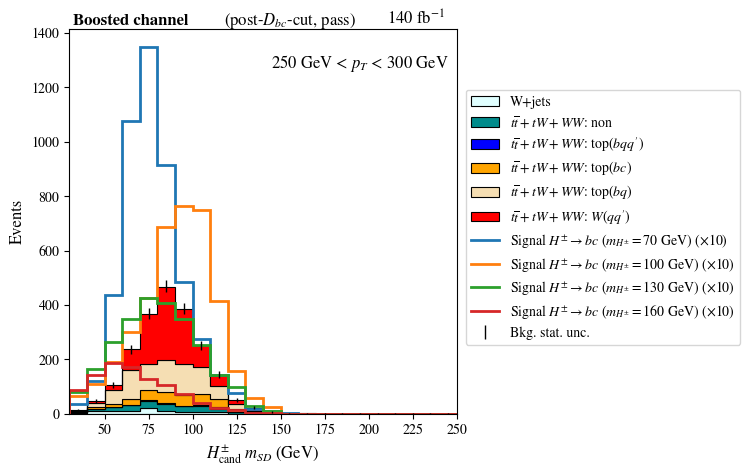

In [25]:
pt_range_index = 1
pass_fail_index = "pass"

basesel_expr_name_var = {
    0 : ("(d.fjcand_p4.pt > 200) & (d.fjcand_p4.pt <= 250)", r"200 GeV < $p_{T}$ < 250 GeV"),
    1 : ("(d.fjcand_p4.pt > 250) & (d.fjcand_p4.pt <= 300)", r"250 GeV < $p_{T}$ < 300 GeV"),
    2 : ("(d.fjcand_p4.pt > 300) & (d.fjcand_p4.pt <= 400)", r"300 GeV < $p_{T}$ < 400 GeV"),
    3 : ("(d.fjcand_p4.pt > 400)", r"$p_{T}$ > 400 GeV")
}

basesel_expr = basesel_expr_name_var[pt_range_index][0]
# basesel_expr = "(d.fjcand_p4.pt > 250) & (d.fjcand_p4.pt < 300)"
# basesel_expr = "(d.fjcand_p4.pt > 300) & (d.fjcand_p4.pt < 400)"
# basesel_expr = "(d.fjcand_p4.pt > 400)"
# basesel_expr = "(ak.num(d.extbtagMPjet_p4) == 2) & (d.dr_extbtagMPjet_12 > 1.) & (d.dr_extbtagMPjet_12_fjcand_min < 2.)"

# try ParticleNetSFs cut:
# basesel_expr = "(d.lep_pt > 50.) & (d.met_pt > 50.) & (d.dr_btagMPjet_lep_min < 2.) & (d.dr_lep_fjcand > 2.) & (d.lepmet_pt > 100.)"

sophon_dnn_selection = {
    0: {"pass" : "& (d.fj_sophon_discr[:,0] > 0.95) &  (d.score_is_w_matched > 0.3)",
        "fail" : "& (d.fj_sophon_discr[:,0] > 0.95) &  (d.score_is_w_matched < 0.3)"},
    1: {"pass" : "& (d.fj_sophon_discr[:,0] > 0.68) &  (d.score_is_w_matched > 0.3)",
        "fail" : "& (d.fj_sophon_discr[:,0] > 0.68) &  (d.score_is_w_matched < 0.3)"},
    2: {"pass" : "& (d.fj_sophon_discr[:,0] > 0.55) &  (d.score_is_w_matched > 0.3)",
        "fail" : "& (d.fj_sophon_discr[:,0] > 0.55) &  (d.score_is_w_matched < 0.3)"},
    3: {"pass" : "& (d.fj_sophon_discr[:,0] > 0.87) &  (d.score_is_w_matched > 0.3)",
        "fail" : "& (d.fj_sophon_discr[:,0] > 0.87) & (d.score_is_w_matched < 0.3)"}
}

basesel_expr += sophon_dnn_selection[pt_range_index][pass_fail_index]

# tagger cut
# basesel_expr += " & (d.fj_sophon_discr[:,0] > 0.95)"
# basesel_expr += " & (d.fj_sophon_discr2[:,0] > 0.5)"
# basesel_expr += " & (d.fj_sophon_probXbc[:,0] / (d.fj_sophon_probXbc[:,0] + d.fj_sophon_probXbq[:,0] + d.fj_sophon_probXcs[:,0] + d.fj_sophon_probXqq[:,0] + d.fj_sophon_probXbqq[:,0] + 10*d.fj_sophon_probQCD[:,0]) > 0.93)"
# basesel_expr += " & (d.fj_sophon_discr2[:,0] > 0.3)"

# DNN cut
# basesel_expr += " & (d.score_is_w_matched < 0.3)"
# basesel_expr += " & (d.score_is_w_matched_pt300 > 0.7)"
# basesel_expr += " & (d.score_is_w_matched_pt400 > 0.1)"

# mass window cut
# basesel_expr += " & (d.fjcand_sdmass > 60) & (d.fjcand_sdmass < 110)"

basesel_expr += " & (d.fjcand_sdmass > 30) & (d.fjcand_sdmass < 250) " 


# basesel_expr = " (d.fjcand_sdmass > 0)"

# varname = "wlep_pt"; varlabel=""; do_plotting = True
varname = "fjcand_sdmass_bw10"; varlabel=r"$H^{\pm}_{\mathrm{cand}}\;m_{SD}$ (GeV)"; do_plotting = True
# varname = "evt_dnn_score"; varlabel="Boosted-channel event classifier score"; do_plotting = True
# varname = "evt_dnn_score_high"; varlabel="Boosted-channel event classifier score"; do_plotting = True
# varname = "fjcand_sdmass_bw10"; varlabel="W cand mass"; do_plotting = True
# varname = "fjcand_pt"; varlabel="W cand pT"; do_plotting = True

# aux weights
actural_lumi = 140. # fb-1

categories_to_draw = [
    # official version
    "bkg_wjets",
    "bkg_non_matched", "bkg_t_matched", "bkg_tbc_matched", "bkg_tbq_matched", "bkg_w_matched",
    # signals
    "sig_tbh_m70", "sig_tbh_m100", "sig_tbh_m130", "sig_tbh_m160",
    ]

varexpr, varaxis = config.variables[varname]
print("Selection:", basesel_expr)
print("Variable:", varexpr)

from scipy.stats import chi2
def garwood_interval(N, alpha=0.317):
    lower_bound = 0 if N == 0 else chi2.ppf(alpha/2, 2*N) / 2
    upper_bound = chi2.ppf(1 - alpha/2, 2*(N+1)) / 2
    return lower_bound, upper_bound

def _concurrent_hist_filler(varaxis, var_array, weight_array, nthreads=1):
    def _fill_hist(input):
        vals, weights = input
        hist = bh.Histogram(varaxis, storage=bh.storage.Weight())
        hist.fill(vals, weight=weights)
        return hist

    if nthreads == 1:
        return _fill_hist((var_array, weight_array))
    else:
        with ThreadPoolExecutor(nthreads) as pool:
            hist = pool.map(_fill_hist, zip(np.array_split(var_array, nthreads), np.array_split(weight_array, nthreads)))
        hist = reduce(add, hist)
        return hist

def _plotter(input):
    cname, sam = input
    print('Processing', cname, sam)
    # base selection
    d = dfc[(cname, sam)]
    d = d[eval(basesel_expr)]
    # fill histogram
    var_array = eval(varexpr)
    weight_array = np.ones(len(d))
    hist = _concurrent_hist_filler(varaxis, var_array, weight_array, nthreads=4)
    # yields ... tbd
    # yld = len(d[(d.fjcand_sdmass > 60) & (d.fjcand_sdmass < 110)])
    yld = len(d)
    return hist, yld

# generate inputs to send into concurrent plotter
zipped_input = []
for cname, (samlist, sel, label, color) in config.categories.items():
    for sam in samlist:
        zipped_input.append((cname, sam))

# plotting
if do_plotting:
    with ThreadPoolExecutor(2) as pool:
        results = dict(zip(zipped_input, pool.map(_plotter, zipped_input)))

# retreive and group results for each category
contents, variances, contents_mass_win = {}, {}, {}
for cname, (samlist, sel, label, color) in config.categories.items():
    hists = []
    contents_mass_win[cname] = 0
    for sam in samlist:
        hists.append(results[(cname, sam)][0] * weights[sam] * (actural_lumi / 450.))
        contents_mass_win[cname] += results[(cname, sam)][1] * weights[sam] * (actural_lumi / 450.)
    hist = sum(hists)
    contents[cname], variances[cname] = hist.view().value, hist.view().variance
    print(cname, round(contents_mass_win[cname], 1))
    
print(
    '**Significance**',
    sum([contents_mass_win[cname] for cname in config.categories if cname.startswith("sig")]) / np.sqrt(sum([contents_mass_win[cname] for cname in config.categories if cname.startswith("bkg")])),
)

# plotting: stacked histogram
fig, ax = plt.subplots(figsize=(5, 5))
hist = bh.Histogram(varaxis, storage=bh.storage.Weight())
hep.histplot(
    [contents[cname] for cname in categories_to_draw if cname.startswith("bkg")],
    bins=hist.axes[0].edges,
    label=[config.categories[cname][2] for cname in categories_to_draw if cname.startswith("bkg")],
    color=[config.categories[cname][3] for cname in categories_to_draw if cname.startswith("bkg")],
    histtype='fill', edgecolor='k', linewidth=0.8, stack=True,
)
# plotting: signals
hep.histplot(
    [contents[cname] * config.signal_mul_factor for cname in categories_to_draw if cname.startswith("sig")],
    bins=hist.axes[0].edges,
    label=[config.categories[cname][2] + f' (×{config.signal_mul_factor})' for cname in categories_to_draw if cname.startswith("sig")],
    # label=[config.categories[cname][2] for cname in categories_to_draw if cname.startswith("sig")],
    linewidth=2,
)
# SM errorbar
## histogram tmpl uncertainty
# ax.errorbar(
#     (hist.axes[0].edges[:-1] + hist.axes[0].edges[1:])/2.,
#     sum([contents[cname] for cname in categories_to_draw if not cname.startswith("sig")]),
#     yerr=np.sqrt(sum([variances[cname] for cname in categories_to_draw if not cname.startswith("sig")])),
#     label='Bkg. unc.', color='black', linewidth=1, linestyle='none',
# )
## mimic the statistical uncertainty
bkg_bin_counts = sum([contents[cname] for cname in categories_to_draw if not cname.startswith("sig")])
bkg_bin_err_lo, bkg_bin_err_hi = abs(bkg_bin_counts - np.array([garwood_interval(N) for N in bkg_bin_counts]).T)
ax.errorbar(
    (hist.axes[0].edges[:-1] + hist.axes[0].edges[1:])/2.,
    bkg_bin_counts,
    yerr=[bkg_bin_err_lo, bkg_bin_err_hi],
    label='Bkg. stat. unc.', color='black', linewidth=1, linestyle='none',
)

ax.set_xlim(varaxis.edges[0], varaxis.edges[-1])
ax.set_xlabel(varlabel, fontsize=12)
ax.set_ylabel("Events", fontsize=12)
# ax.set_yscale("log")
ax.legend(prop={'size': 10}, loc='upper right', ncol=1, columnspacing=0.6, labelspacing=0.4, bbox_to_anchor=(1.75, 0.86))#, handletextpad=0.2, borderpad=0.5)

# ax.legend(prop={'size': 8}, loc='best', ncol=1, columnspacing=0.6, labelspacing=0.4)#, handletextpad=0.2, borderpad=0.5)


ax.text(0.01, 1.01, r"Boosted channel", fontsize=12, fontweight='bold', transform=ax.transAxes)
ax.text(0.4, 1.01, r"(post-$D_{bc}$-cut, " + f"{pass_fail_index})", fontsize=12, transform=ax.transAxes)
ax.text(0.52, 0.9, basesel_expr_name_var[pt_range_index][1], fontsize=12, transform=ax.transAxes)

ax.text(0.82, 1.01, r"%d $\mathrm{fb}^{-1}$" % actural_lumi, fontsize=12, transform=ax.transAxes)
plt.savefig(f"./plots/v11/{varname}_{pt_range_index}_{pass_fail_index}_final.pdf", bbox_inches='tight')
plt.show()

### Updated plotting

In [ ]:
pt_range_index = 1
# pass_fail_index = "pass"
basesel_expr_name_var = {
    0 : ("(d.fjcand_sdmass > 30) & (d.fjcand_sdmass < 250) & (d.fjcand_p4.pt > 200) & (d.fjcand_p4.pt <= 250)", r"200 GeV < $p_{T}$ < 250 GeV"),
    1 : ("(d.fjcand_sdmass > 30) & (d.fjcand_sdmass < 250) & (d.fjcand_p4.pt > 250) & (d.fjcand_p4.pt <= 300)", r"250 GeV < $p_{T}$ < 300 GeV"),
    2 : ("(d.fjcand_sdmass > 30) & (d.fjcand_sdmass < 250) & (d.fjcand_p4.pt > 300) & (d.fjcand_p4.pt <= 400)", r"300 GeV < $p_{T}$ < 400 GeV"),
    3 : ("(d.fjcand_sdmass > 30) & (d.fjcand_sdmass < 250) & (d.fjcand_p4.pt > 400)", r"$p_{T}$ > 400 GeV")
}

categories_to_draw = [
    # official version
    "bkg_wjets",
    "bkg_non_matched", "bkg_t_matched", "bkg_tbc_matched", "bkg_tbq_matched", "bkg_w_matched",
    # signals
    "sig_tbh_m70", "sig_tbh_m100", "sig_tbh_m130", "sig_tbh_m160",
    ]

sophon_dnn_selection = {
    0: {"pass" : "& (d.fj_sophon_discr[:,0] > 0.95) &  (d.score_is_w_matched > 0.3)",
        "fail" : "& (d.fj_sophon_discr[:,0] > 0.95) &  (d.score_is_w_matched < 0.3)"},
    1: {"pass" : "& (d.fj_sophon_discr[:,0] > 0.68) &  (d.score_is_w_matched > 0.3)",
        "fail" : "& (d.fj_sophon_discr[:,0] > 0.68) &  (d.score_is_w_matched < 0.3)"},
    2: {"pass" : "& (d.fj_sophon_discr[:,0] > 0.55) &  (d.score_is_w_matched > 0.3)",
        "fail" : "& (d.fj_sophon_discr[:,0] > 0.55) &  (d.score_is_w_matched < 0.3)"},
    3: {"pass" : "& (d.fj_sophon_discr[:,0] > 0.87) &  (d.score_is_w_matched > 0.3)",
        "fail" : "& (d.fj_sophon_discr[:,0] > 0.87) & (d.score_is_w_matched < 0.3)"}
}

varname = "fjcand_sdmass_bw10"; varlabel=r"$H^{\pm}_{\mathrm{cand}}\;m_{SD}$ (GeV)"; do_plotting = True

actural_lumi = 140. # fb-1

from scipy.stats import chi2
def garwood_interval(N, alpha=0.317):
    lower_bound = 0 if N == 0 else chi2.ppf(alpha/2, 2*N) / 2
    upper_bound = chi2.ppf(1 - alpha/2, 2*(N+1)) / 2
    return lower_bound, upper_bound

def _concurrent_hist_filler(varaxis, var_array, weight_array, nthreads=1):
    def _fill_hist(input):
        vals, weights = input
        hist = bh.Histogram(varaxis, storage=bh.storage.Weight())
        hist.fill(vals, weight=weights)
        return hist

    if nthreads == 1:
        return _fill_hist((var_array, weight_array))
    else:
        with ThreadPoolExecutor(nthreads) as pool:
            hist = pool.map(_fill_hist, zip(np.array_split(var_array, nthreads), np.array_split(weight_array, nthreads)))
        hist = reduce(add, hist)
        return hist

def _plotter(input):
    cname, sam = input
    print('Processing', cname, sam)
    # base selection
    d = dfc[(cname, sam)]
    d = d[eval(basesel_expr)]
    # fill histogram
    var_array = eval(varexpr)
    weight_array = np.ones(len(d))
    hist = _concurrent_hist_filler(varaxis, var_array, weight_array, nthreads=4)
    # yields ... tbd
    # yld = len(d[(d.fjcand_sdmass > 60) & (d.fjcand_sdmass < 110)])
    yld = len(d)
    return hist, yld

# done common settings
# firstly plot pass
basesel_expr = basesel_expr_name_var[pt_range_index][0]

basesel_expr += sophon_dnn_selection[pt_range_index]["pass"]

varexpr, varaxis = config.variables[varname]
print("Selection:", basesel_expr)
print("Variable:", varexpr)

# generate inputs to send into concurrent plotter
zipped_input = []
for cname, (samlist, sel, label, color) in config.categories.items():
    for sam in samlist:
        zipped_input.append((cname, sam))

# plotting
if do_plotting:
    with ThreadPoolExecutor(2) as pool:
        results = dict(zip(zipped_input, pool.map(_plotter, zipped_input)))

# retreive and group results for each category
contents, variances, contents_mass_win = {}, {}, {}
for cname, (samlist, sel, label, color) in config.categories.items():
    hists = []
    contents_mass_win[cname] = 0
    for sam in samlist:
        hists.append(results[(cname, sam)][0] * weights[sam] * (actural_lumi / 450.))
        contents_mass_win[cname] += results[(cname, sam)][1] * weights[sam] * (actural_lumi / 450.)
    hist = sum(hists)
    contents[cname], variances[cname] = hist.view().value, hist.view().variance
    print(cname, round(contents_mass_win[cname], 1))
    
print(
    '**Significance**',
    sum([contents_mass_win[cname] for cname in config.categories if cname.startswith("sig")]) / np.sqrt(sum([contents_mass_win[cname] for cname in config.categories if cname.startswith("bkg")])),
)

# plotting: stacked histogram
# fig, ax = plt.subplots(figsize=(5, 5))

# below are for fail

basesel_expr = basesel_expr_name_var[pt_range_index][0]

basesel_expr += sophon_dnn_selection[pt_range_index]["pass"]

varexpr, varaxis = config.variables[varname]
print("Selection:", basesel_expr)
print("Variable:", varexpr)

# generate inputs to send into concurrent plotter
zipped_input = []
for cname, (samlist, sel, label, color) in config.categories.items():
    for sam in samlist:
        zipped_input.append((cname, sam))

# plotting
if do_plotting:
    with ThreadPoolExecutor(2) as pool:
        results = dict(zip(zipped_input, pool.map(_plotter, zipped_input)))

# retreive and group results for each category
contents, variances, contents_mass_win = {}, {}, {}
for cname, (samlist, sel, label, color) in config.categories.items():
    hists = []
    contents_mass_win[cname] = 0
    for sam in samlist:
        hists.append(results[(cname, sam)][0] * weights[sam] * (actural_lumi / 450.))
        contents_mass_win[cname] += results[(cname, sam)][1] * weights[sam] * (actural_lumi / 450.)
    hist = sum(hists)
    contents[cname], variances[cname] = hist.view().value, hist.view().variance
    print(cname, round(contents_mass_win[cname], 1))
    
print(
    '**Significance**',
    sum([contents_mass_win[cname] for cname in config.categories if cname.startswith("sig")]) / np.sqrt(sum([contents_mass_win[cname] for cname in config.categories if cname.startswith("bkg")])),
)

# plot

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

hist = bh.Histogram(varaxis, storage=bh.storage.Weight())
hep.histplot(
    [contents[cname] for cname in categories_to_draw if cname.startswith("bkg")],
    bins=hist.axes[0].edges,
    label=[config.categories[cname][2] for cname in categories_to_draw if cname.startswith("bkg")],
    color=[config.categories[cname][3] for cname in categories_to_draw if cname.startswith("bkg")],
    histtype='fill', edgecolor='k', linewidth=0.8, stack=True, ax = ax1
)
# plotting: signals
hep.histplot(
    [contents[cname] * config.signal_mul_factor for cname in categories_to_draw if cname.startswith("sig")],
    bins=hist.axes[0].edges,
    label=[config.categories[cname][2] + f' (×{config.signal_mul_factor})' for cname in categories_to_draw if cname.startswith("sig")],
    # label=[config.categories[cname][2] for cname in categories_to_draw if cname.startswith("sig")],
    linewidth=2,
    ax = ax1
)

## mimic the statistical uncertainty
bkg_bin_counts = sum([contents[cname] for cname in categories_to_draw if not cname.startswith("sig")])
bkg_bin_err_lo, bkg_bin_err_hi = abs(bkg_bin_counts - np.array([garwood_interval(N) for N in bkg_bin_counts]).T)
ax.errorbar(
    (hist.axes[0].edges[:-1] + hist.axes[0].edges[1:])/2.,
    bkg_bin_counts,
    yerr=[bkg_bin_err_lo, bkg_bin_err_hi],
    label='Bkg. stat. unc.', color='black', linewidth=1, linestyle='none',
)

ax.set_xlim(varaxis.edges[0], varaxis.edges[-1])
ax.set_xlabel(varlabel, fontsize=12)
ax.set_ylabel("Events", fontsize=12)
# ax.set_yscale("log")
ax.legend(prop={'size': 10}, loc='upper right', ncol=1, columnspacing=0.6, labelspacing=0.4, bbox_to_anchor=(1.75, 0.86))#, handletextpad=0.2, borderpad=0.5)

# ax.legend(prop={'size': 8}, loc='best', ncol=1, columnspacing=0.6, labelspacing=0.4)#, handletextpad=0.2, borderpad=0.5)


ax.text(0.01, 1.01, r"Boosted channel", fontsize=12, fontweight='bold', transform=ax.transAxes)
ax.text(0.4, 1.01, r"(post-$D_{bc}$-cut, " + f"{pass_fail_index})", fontsize=12, transform=ax.transAxes)
ax.text(0.52, 0.9, basesel_expr_name_var[pt_range_index][1], fontsize=12, transform=ax.transAxes)

ax.text(0.82, 1.01, r"%d $\mathrm{fb}^{-1}$" % actural_lumi, fontsize=12, transform=ax.transAxes)

plt.savefig(f"./plots/v11/{varname}_{pt_range_index}_{pass_fail_index}_final.pdf", bbox_inches='tight')
plt.show()

### New templates

In [8]:
import pickle

with open("/home/pku/zhaoyz/pheno/notebooks_hbc/pickles/wcb_tbhana_templ_3dhist_v0318.pickle", "rb") as f:
    templs_summary_3d = pickle.load(f)

In [ ]:
templs_summary_3d.keys()

In [ ]:
print(templs_summary_3d["pt200to250_nom"]["bkg_allwhad_others"][::bh.sum,::bh.sum,3:])

In [ ]:
print(templs_summary_3d["pt200to250_nom"]["bkg_allwhad_others"][1::bh.sum,::bh.sum,::bh.sum])

In [ ]:
print(templs_summary_3d["pt200to250_nom"]["bkg_allwhad_others"][2::bh.sum,::bh.sum,::bh.sum])

In [9]:
print(templs_summary_3d["pt200to250_nom"]["bkg_allwhad_others"][::bh.sum,:,::bh.sum])

                       ┌─────────────────────────────────────────────────────┐
[-inf,    0) 0         │                                                     │
[   0, 0.05) 2.481e+06 │████████████████████████████████████████████████████ │
[0.05,  0.1) 7.121e+05 │██████████████▉                                      │
[ 0.1, 0.15) 3.487e+05 │███████▎                                             │
[0.15,  0.2) 2.491e+05 │█████▎                                               │
[ 0.2, 0.25) 2.342e+05 │████▉                                                │
[0.25,  0.3) 1.05e+05  │██▎                                                  │
[ 0.3,    1) 3.632e+05 │███████▋                                             │
[   1,  inf) 0         │                                                     │
                       └─────────────────────────────────────────────────────┘


In [ ]:
print(templs_summary_3d["pt200to250_nom"]["bkg_allwhad_others"][::bh.sum,:1:bh.sum,:])

In [ ]:
def rebin_hist_var_width(orig_hist, new_axis):
    new_hist = bh.Histogram(new_axis, storage=bh.storage.Weight())
    for i in range(orig_hist.axes[0].size):
        bin_center = orig_hist.axes[0].centers[i]
        if bin_center > new_axis.edges[0] and bin_center < new_axis.edges[-1]:
            new_idx = np.searchsorted(new_axis.edges, bin_center) - 1
            new_hist.view().value[new_idx] += orig_hist.view().value[i]
            new_hist.view().variance[new_idx] += orig_hist.view().variance[i]
    return new_hist

In [ ]:
sophon_discr_thres = 0.51
(int(sophon_discr_thres*100)-50)

In [ ]:
print(templs_summary_3d["pt200to250_nom"]["bkg_allwhad_others"][::bh.sum,:,::bh.sum])

In [ ]:
evt_dnn_thres = 0.05
int((int(evt_dnn_thres*100))/5)

In [ ]:
sophon_discr_thres  = {
    "pt200to250" : 0.95,
    "pt250to300" : 0.85,
    "pt300to400" : 0.9,
    "pt400toInf" : 0.9
}
sophon_discr_thres["pt200to250"]

In [32]:
filedir = './datacards'
aux_weight_scale = 140. / 450 # for Full-Run2
print('Apply aux weight scale:', aux_weight_scale)

import copy
# _templs_pass = copy.deepcopy(templs_summary_pass) ## important!
# _templs_fail = copy.deepcopy(templs_summary_fail) ## important!

_templs = copy.deepcopy(templs_summary_3d)

# hist_out = {}

# sophon_discr_thres = 0.951; evt_dnn_thres = 0.87  # 0.951, 0.87 optimal for strength=1; 0.95, 0.86 optimal for strength=0.5

sophon_discr_thres  = {
    "pt200to250" : 0.95,
    "pt250to300" : 0.92,
    "pt300to400" : 0.91,
    "pt400toInf" : 0.9
}

evt_dnn_thres  = {
    "pt200to250" : 0.3,
    "pt250to300" : 0.3,
    "pt300to400" : 0.3,
    "pt400toInf" : 0.1
}

for sig_idx, sig_sam in enumerate(list(config.sig_list.keys())):
    sig_sam_dir = f"{filedir}/{sig_sam}"
    _ = os.system(f"mkdir -p {sig_sam_dir}")
    clist = list(config.bkg_list.keys()) + [sig_sam] # categories to run for one mass point
    
    data_obs_pass = {}
    data_obs_fail = {}
    
    for pt_bin in ["pt200to250","pt250to300","pt300to400","pt400toInf"]:
        hist_out_pass = {}
        hist_out_fail = {}
        for cm in clist:
            hist_out_pass[f"{cm}"] = copy.deepcopy(_templs[f"{pt_bin}_nom"][cm][(int(sophon_discr_thres[pt_bin]*100)-49)::bh.sum, int((int(evt_dnn_thres[pt_bin]*100))/5)::bh.sum, 3:])        # nominal value/hist
            hist_out_fail[f"{cm}"] = copy.deepcopy(_templs[f"{pt_bin}_nom"][cm][(int(sophon_discr_thres[pt_bin]*100)-49)::bh.sum, 0:int((int(evt_dnn_thres[pt_bin]*100))/5):bh.sum, 3:])       # nominal value/hist
            
        for target_flv in ["bjet", "cjet", "ljet"]:
            for target_region in ["B1", "B2", "C1", "C2", "N"]:
                for target_variation in ["up", "down"]:
                    _variation = "Up" if target_variation == "up" else "Down"
                    
                    # for all bkg
                    nevt_tot_nom = sum(_templs[f"{pt_bin}_nom"][cm].view(flow=True).value.sum() for cm in config.bkg_list)
                    nevt_tot_flv = sum(_templs[f"{pt_bin}_{target_flv}_{target_region}_{target_variation}"][cm].view(flow=True).value.sum() for cm in config.bkg_list)
                    fac =  nevt_tot_nom / nevt_tot_flv

                    for cm in config.bkg_list:
                        n = f"{cm}_ftag_{target_flv}_{target_region}{_variation}"

                        hist_out_pass[n] = copy.deepcopy(_templs[f"{pt_bin}_{target_flv}_{target_region}_{target_variation}"][cm][(int(sophon_discr_thres[pt_bin]*100)-49)::bh.sum, int((int(evt_dnn_thres[pt_bin]*100))/5)::bh.sum, 3:])
                        hist_out_pass[n].view().value *= fac
                        hist_out_pass[n].view().value = np.maximum(hist_out_pass[n].view().value, 1e-3)
                        hist_out_pass[n].view().variance *= 0
                        
                        hist_out_fail[n] = copy.deepcopy(_templs[f"{pt_bin}_{target_flv}_{target_region}_{target_variation}"][cm][(int(sophon_discr_thres[pt_bin]*100)-49)::bh.sum, 0:int((int(evt_dnn_thres[pt_bin]*100))/5):bh.sum, 3:])
                        hist_out_fail[n].view().value *= fac
                        hist_out_fail[n].view().value = np.maximum(hist_out_fail[n].view().value, 1e-3)
                        hist_out_fail[n].view().variance *= 0

                    # for sig
                    nevt_tot_nom = sum(_templs[f"{pt_bin}_nom"][cm].view(flow=True).value.sum() for cm in [sig_sam])
                    nevt_tot_flv = sum(_templs[f"{pt_bin}_{target_flv}_{target_region}_{target_variation}"][cm].view(flow=True).value.sum() for cm in [sig_sam])
                    fac =  nevt_tot_nom / nevt_tot_flv
                    
                    for cm in [sig_sam]:
                        n = f"{cm}_ftag_{target_flv}_{target_region}{_variation}"
                        
                        hist_out_pass[n] = copy.deepcopy(_templs[f"{pt_bin}_{target_flv}_{target_region}_{target_variation}"][cm][(int(sophon_discr_thres[pt_bin]*100)-49)::bh.sum, int((int(evt_dnn_thres[pt_bin]*100))/5)::bh.sum, 3:])
                        hist_out_pass[n].view().value *= fac
                        hist_out_pass[n].view().value = np.maximum(hist_out_pass[n].view().value, 1e-3)
                        hist_out_pass[n].view().variance *= 0
                        
                        hist_out_fail[n] = copy.deepcopy(_templs[f"{pt_bin}_{target_flv}_{target_region}_{target_variation}"][cm][(int(sophon_discr_thres[pt_bin]*100)-49)::bh.sum, 0:int((int(evt_dnn_thres[pt_bin]*100))/5):bh.sum, 3:])
                        hist_out_fail[n].view().value *= fac
                        hist_out_fail[n].view().value = np.maximum(hist_out_fail[n].view().value, 1e-3)
                        hist_out_fail[n].view().variance *= 0

        hist_out_pass[f'data_obs'] = sum(hist_out_pass[f"{cm}"] for cm in config.bkg_list)
        hist_out_fail[f'data_obs'] = sum(hist_out_fail[f"{cm}"] for cm in config.bkg_list)
        
        # aux weight scale
        # print(1,hist_out_pass)
        for n in hist_out_pass:
            hist_out_pass[n].view().value *= aux_weight_scale
            # hist_out[n].view().variance *= aux_weight_scale**2
            hist_out_pass[n].view().variance *= 0
        # print(2,hist_out_pass)
        for n in hist_out_fail:
            hist_out_fail[n].view().value *= aux_weight_scale
            # hist_out[n].view().variance *= aux_weight_scale**2
            hist_out_fail[n].view().variance *= 0
            
        data_obs_pass[pt_bin] = hist_out_pass[f'data_obs'].values().sum()
        data_obs_fail[pt_bin] = hist_out_fail[f'data_obs'].values().sum()
        
        print(f"{sig_sam} & {pt_bin} pass observation:", hist_out_pass[f'data_obs'].values().sum())
        print(f"{sig_sam} & {pt_bin} fail observation:", hist_out_fail[f'data_obs'].values().sum())

        with uproot.recreate(f'{sig_sam_dir}/input_{pt_bin}_pass.root') as fw:
            for n in hist_out_pass:
                if "sig" not in n:
                    fw[n] = hist_out_pass[n]
                else:
                    # need to rename, e.g., "sig_m60" to "sig"
                    sig_name = n.replace(sig_sam, "sig")
                    fw[sig_name] = hist_out_pass[n]

        with uproot.recreate(f'{sig_sam_dir}/input_{pt_bin}_fail.root') as fw:
            for n in hist_out_fail:
                if "sig" not in n:
                    fw[n] = hist_out_fail[n]
                else:
                    # need to rename, e.g., "sig_m60" to "sig"
                    sig_name = n.replace(sig_sam, "sig")
                    fw[sig_name] = hist_out_fail[n]
                    
        # print("check:", data_obs_dict[pt_bin], hist_out[n].values().sum())
                        
    print("pass",data_obs_pass)
    print("fail",data_obs_fail)
    lines = open(f'{filedir}/datacard_tmpl.txt').readlines()
    for i, line in enumerate(lines):
        if line.startswith('observation'):
            lines[i] = f'observation {data_obs_pass["pt200to250"]} {data_obs_pass["pt250to300"]} {data_obs_pass["pt300to400"]} {data_obs_pass["pt400toInf"]} {data_obs_fail["pt200to250"]} {data_obs_fail["pt250to300"]} {data_obs_fail["pt300to400"]} {data_obs_fail["pt400toInf"]}\n'
    
    with open(f'{sig_sam_dir}/datacard.txt', 'w') as f:
        f.writelines(lines)
    print("\n")

Apply aux weight scale: 0.3111111111111111
sig_m60 & pt200to250 pass observation: 103.26224176963495
sig_m60 & pt200to250 fail observation: 4531.875819267008
sig_m60 & pt250to300 pass observation: 107.33804181587743
sig_m60 & pt250to300 fail observation: 5943.567395694117
sig_m60 & pt300to400 pass observation: 99.48751282058603
sig_m60 & pt300to400 fail observation: 7583.47966705023
sig_m60 & pt400toInf pass observation: 1039.6855327351395
sig_m60 & pt400toInf fail observation: 2738.05116558162
pass {'pt200to250': 103.26224176963495, 'pt250to300': 107.33804181587743, 'pt300to400': 99.48751282058603, 'pt400toInf': 1039.6855327351395}
fail {'pt200to250': 4531.875819267008, 'pt250to300': 5943.567395694117, 'pt300to400': 7583.47966705023, 'pt400toInf': 2738.05116558162}


sig_m70 & pt200to250 pass observation: 103.26224176963495
sig_m70 & pt200to250 fail observation: 4531.875819267008
sig_m70 & pt250to300 pass observation: 107.33804181587743
sig_m70 & pt250to300 fail observation: 5943.5673

### Plot the limits

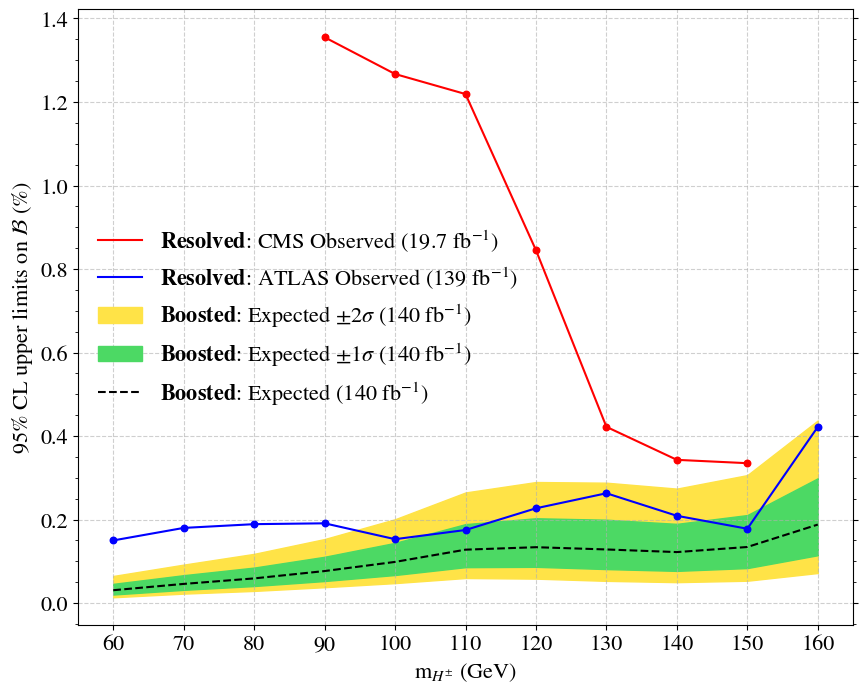

In [33]:
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import AutoMinorLocator
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

# plt.rcParams['text.usetex'] = True

folder_path = "/home/pku/zhaoyz/pheno/notebooks_hbc/datacards"
mass_points = [mp for mp in range(60, 170, 10)]
observed_limits = []
expected_2_5 = []
expected_16 = []
expected_50 = []
expected_84 = []
expected_97_5 = []

for sig_idx, sig_sam in enumerate(list(config.sig_list.keys())):
    folder_path_i = f"{folder_path}/{sig_sam}"
    filename = "ObservedAsymptoticLimits.txt"
    file_path = os.path.join(folder_path_i, filename)
    with open(file_path, "r") as file:
        content = file.read()
        pattern = r"r < (\d+\.\d+)"
        limits = re.findall(pattern, content)
        limits = [float(limit) for limit in limits]
        observed_limits.append(limits[0])
        expected_2_5.append(limits[1])
        expected_16.append(limits[2])
        expected_50.append(limits[3])
        expected_84.append(limits[4])
        expected_97_5.append(limits[5])

plt.figure(figsize=(10, 8))

# plt.rcParams["text.usetex"] = True  # 全局启用（可选）

# observed CMS
cms_observed_mass = [90, 100, 110, 120, 130, 140, 150]
cms_observed_value = [1.355, 1.267, 1.219, 0.845, 0.422, 0.343, 0.335]
plt.scatter(cms_observed_mass, cms_observed_value, color='red',  zorder=10, s = 22)
plt.plot(cms_observed_mass, cms_observed_value, color='red', linestyle='-', label=r'$\mathbf{Resolved}$: CMS Observed (19.7 $\mathrm{fb^{-1}}$)', zorder=8)

# observed ATLAS
cms_observed_mass  = [60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160]
cms_observed_value = [0.150, 0.180, 0.189, 0.191, 0.153, 0.175, 0.227, 0.263, 0.209, 0.178, 0.422]
plt.scatter(cms_observed_mass, cms_observed_value, color='blue',  zorder=10, s = 22)
plt.plot(cms_observed_mass, cms_observed_value, color='blue', linestyle='-', label=r'$\mathbf{Resolved}$: ATLAS Observed (139 $\mathrm{fb^{-1}}$)', zorder=8)

# plot settings
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='y', which='both', right=True)  # 启用右轴的刻度和次要刻度

ax.set_xticks([60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160])  # 显式指定刻度位置

# 填充 Brazil Band 区域
plt.fill_between(mass_points, expected_2_5, expected_97_5, color='#ffe347', label=r'$\mathbf{Boosted}$: Expected $\pm2 \sigma$ (140 $\mathrm{fb^{-1}}$)') # r'Expected $\pm2 \sigma$'
plt.fill_between(mass_points, expected_16, expected_84, color='#4cd964', label=r'$\mathbf{Boosted}$: Expected $\pm1 \sigma$ (140 $\mathrm{fb^{-1}}$)') # r'Expected $\pm1 \sigma$'

# 绘制 Expected 50% 线
plt.plot(mass_points, expected_50, color='black', linestyle='--', label=r'$\mathbf{Boosted}$: Expected (140 $\mathrm{fb^{-1}}$)')

# 绘制 Observed Limit 线
# plt.plot(mass_points, observed_limits, color='red', marker='o', label='Observed Limit')

# 添加标签和标题
plt.xlabel(r'$\mathcal{m}_{H^{\pm}}$ (GeV)', fontsize=16)
plt.ylabel('95% CL upper limits on ' + r'$\mathcal{B}$' + " (%)", fontsize=16)
# plt.title('Brazil Band Plot', fontsize=16)
plt.legend(loc='best', fontsize=16, frameon = False)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tick_params(axis='x', labelsize=16)  # x轴刻度字体大小
plt.tick_params(axis='y', labelsize=16)  # y轴刻度字体大小
# 显示图像

plt.savefig(f"./exclude_v11.pdf", bbox_inches='tight')
plt.show()